In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('bofa_ice_sovereign_bonds_returns.csv')

In [3]:
df = df.set_index('Unnamed: 0')

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df = df.sort_index()

In [6]:
df = df.ffill().fillna(0).pct_change().fillna(0)

In [7]:
X = df.copy()

In [8]:
X = X.replace(to_replace=float('inf'), value=0)

In [9]:
def strategy(returns: pd.DataFrame, V_0=1, window=120, horizon=7, benchmark=False, GAMMA=1):
    V = V_0
    portfolio_value = [V]
    returns_value = [0]
    pnl = []
        
    # for each week we perform the optimisation
    for i in range(0, len(returns)-window-horizon, horizon):
        if benchmark:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns[:-1]))+['GDZM Index']))
            w = np.ones(len(tradable))/len(tradable)
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        else:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns[:-1]))+['GDZM Index']))
            inv_corr = np.linalg.inv(X.iloc[i:i+window][tradable].corr())
            num = np.dot(inv_corr, np.ones(len(inv_corr)))
            den = np.dot(np.ones(len(inv_corr)), inv_corr)@np.ones(len(inv_corr))
            w = num/den
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        portfolio_value.append(V)
        returns_value.append(portfolio_value[-1]/portfolio_value[-2]-1)
    return V, portfolio_value, returns_value

In [17]:
perf, value, rtns = strategy(X, horizon=30, benchmark=False)

In [10]:
def plot_performance(value, rtns, title=None):
    fig, axs = plt.subplots(2, figsize=(12,6))
    fig.suptitle(title if title else 'Plot of portfolio value and returns over time')
    axs[0].plot(value)
    axs[1].plot(rtns)
    plt.show()

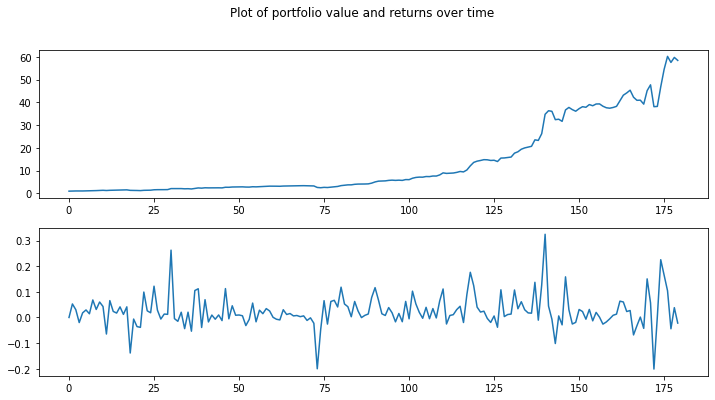

In [28]:
plot_performance(value, rtns)

In [29]:
perf_bench, value_bench, rtns_bench = strategy(X, horizon=30, benchmark=True)

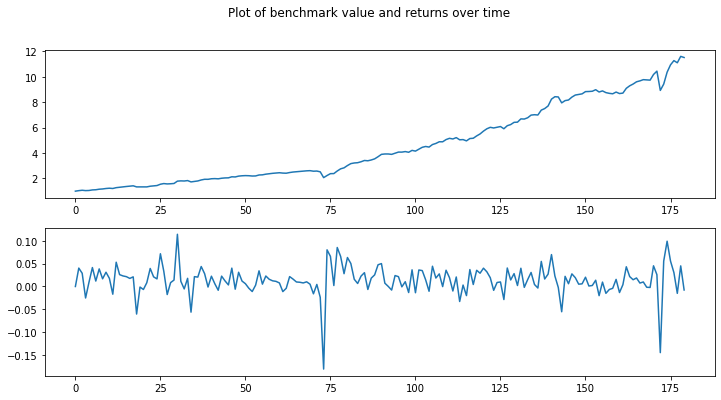

In [30]:
plot_performance(value_bench, rtns_bench, title="Plot of benchmark value and returns over time")

In [12]:
equities = pd.read_csv('../Data/country_data/ETF_adj_close_v2.csv')

In [16]:
equities = equities.rename(columns={'Unnamed: 0': 'trdate'})

In [17]:
equities = equities.set_index('trdate')
equities = equities.sort_index()

In [18]:
equities = equities.ffill().fillna(0).pct_change().fillna(0)

In [19]:
equities = equities.replace(to_replace=float('inf'), value=0)

In [20]:
equities

,Argentina,Brazil,Chile,China,Colombia,Egypt,Greece,India,Indonesia,Korea,...,Philippines,Poland,Qatar,Russia,Saudi Arabia,South Africa,Taiwan,Thailand,Turkey,United Arab Emirates
trdate,,,,,,,,,,,,,,,,,,,,,
1996-03-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-19,0.014764,-0.005693,0.002203,0.035844,-0.002629,-0.001127,0.019758,0.003415,-0.013883,0.004337,...,-0.020315,0.003125,-0.005233,-0.004273,-0.009071,0.026861,0.009269,-0.011463,0.017903,0.054502
2021-01-20,0.012286,-0.000545,0.024490,0.030207,0.004394,0.013910,0.005536,0.020909,0.036853,0.013818,...,-0.004643,0.004673,-0.000421,0.008079,0.005998,0.017956,-0.000173,0.009327,0.018665,0.020974
2021-01-21,-0.021718,-0.018549,0.001532,-0.003282,-0.008749,0.006303,-0.005112,-0.004525,-0.004393,0.022681,...,0.004353,-0.011886,-0.000105,-0.020035,-0.003138,0.002178,0.017331,0.002248,-0.007400,-0.021717


In [21]:
X = equities.copy()

In [22]:
X

,Argentina,Brazil,Chile,China,Colombia,Egypt,Greece,India,Indonesia,Korea,...,Philippines,Poland,Qatar,Russia,Saudi Arabia,South Africa,Taiwan,Thailand,Turkey,United Arab Emirates
trdate,,,,,,,,,,,,,,,,,,,,,
1996-03-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-03-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-19,0.014764,-0.005693,0.002203,0.035844,-0.002629,-0.001127,0.019758,0.003415,-0.013883,0.004337,...,-0.020315,0.003125,-0.005233,-0.004273,-0.009071,0.026861,0.009269,-0.011463,0.017903,0.054502
2021-01-20,0.012286,-0.000545,0.024490,0.030207,0.004394,0.013910,0.005536,0.020909,0.036853,0.013818,...,-0.004643,0.004673,-0.000421,0.008079,0.005998,0.017956,-0.000173,0.009327,0.018665,0.020974
2021-01-21,-0.021718,-0.018549,0.001532,-0.003282,-0.008749,0.006303,-0.005112,-0.004525,-0.004393,0.022681,...,0.004353,-0.011886,-0.000105,-0.020035,-0.003138,0.002178,0.017331,0.002248,-0.007400,-0.021717


In [29]:
perf, value, rtns = strategy(X, window=120, horizon=7, benchmark=True)

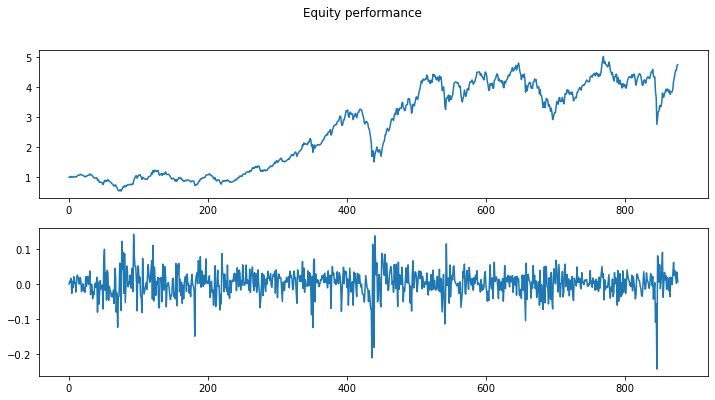

In [31]:
plot_performance(value, rtns, title="Equity performance")

In [27]:
perf_bench, value_bench, rtns_bench = strategy(X, window=60, horizon=7, benchmark=True)

In [28]:
perf_bench

4.450669505937858

In [28]:
perf_bench

4.450669505937858

In [2]:
response = pd.read_excel('../Data/macro_factors/GBI-EM.xlsx')
new_header = response.loc[5]
gbi_em = response.loc[6:]
gbi_em.columns = new_header
gbi_em = gbi_em[['Date', 'PX_LAST']]
gbi_em.Date = pd.to_datetime(gbi_em.Date)
gbi_em = gbi_em.set_index('Date').sort_index().pct_change()

In [31]:
features = pd.read_excel('../Data/country_data/ice_bofa_sovereign_indices_data.xlsx', sheet_name='return data', skiprows=3)
features = features.loc[2:].rename(columns={'Unnamed: 0': 'date'}).set_index('date').fillna(0).sort_index()

In [32]:
gbi_em = gbi_em.sort_index().pct_change()

In [33]:
new_df = features.merge(gbi_em, left_on=features.index, right_on=gbi_em.index, how='inner')

In [36]:
features['GDBO Index']

date
2000-01-03     0.0000
2000-01-04     0.0000
2000-01-05     0.0000
2000-01-06     0.0000
2000-01-07     0.0000
               ...   
2021-01-18    33.3333
2021-01-19    33.3333
2021-01-20    25.0000
2021-01-21     0.0000
2021-01-22     0.0000
Name: GDBO Index, Length: 5495, dtype: float64

In [7]:
new_df = new_df.set_index('key_0').resample('W').sum()

## Regression of the assets' performance on our benchmark

In [103]:
X = new_df.bfill()[new_df.columns[1:-1]]
y = new_df.bfill()[new_df.columns[-1]].clip(-600, 600)
X['const'] = 1

In [105]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PX_LAST   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.188
Date:                Thu, 04 Feb 2021   Prob (F-statistic):              0.140
Time:                        02:35:12   Log-Likelihood:                -5373.2
No. Observations:                 942   AIC:                         1.090e+04
Df Residuals:                     866   BIC:                         1.127e+04
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GDAO Index     2.5876      2.326      1.113      0.266      -1.977       7.152
GDAR Index -2.074e-11   5.79e-11     -0.358      0.720   -1.34e-10     9.3e-11
GDAW Index    -2.0542      6.959     -0.295      0.768     -15.713      11.605
GDAZ Index     7.2951      4.578      1.593      0.111      -1.691      16.281
GDBB Index    -0.8703      1.986     -0.438      0.661      -4.769       3.028
GDBG Index   -12.3298      6.109     -2.018      0.044     -24.320      -0.340
GDBH Index    14.0609     18.200      0.773      0.440     -21.660      49.782
GDBO Index     0.0049      0.023      0.215      0.830      -0.040       0.050
GDBR Index     2.9619      3.342      0.886      0.376      -3.598       9.522
GDBS Index    -2.6602      2.896     -0.918      0.359      -8.345       3.024
GDBY Index     0.7204      1.406      0.513      0.608      -2.038       3.479
GDBZ Index    -0.0183      1.039     -0.018      0.986      -2.057       2.021
GDCI Index    -0.9550      2.571     -0.372      0.710      -6.000       4.090
GDCL Index    -6.0765      5.499     -1.105      0.269     -16.869       4.716
GDCN Index    11.8917     10.187      1.167      0.243      -8.102      31.886
GDCO Index    -5.6529      5.058     -1.118      0.264     -15.579       4.274
GDCR Index    -1.4166      2.957     -0.479      0.632      -7.220       4.387
GDCS Index     0.1463      0.575      0.254      0.799      -0.983       1.275
GDDO Index     1.3439      1.765      0.761      0.447      -2.121       4.809
GDDZ Index    25.2556     27.467      0.919      0.358     -28.654      79.165
GDEC Index     0.6152      0.684      0.900      0.368      -0.727       1.957
GDEG Index    -0.6080      2.585     -0.235      0.814      -5.682       4.466
GDES Index     1.0472     11.813      0.089      0.929     -22.138      24.232
GDFJ Index    -0.2963      6.574     -0.045      0.964     -13.198      12.606
GDGA Index     0.9161      2.491      0.368      0.713      -3.973       5.805
GDGE Index     4.0502      2.392      1.694      0.091      -0.644       8.744
GDGH Index     3.4539      2.195      1.574      0.116      -0.854       7.762
GDGR Index    -5.0550     17.752     -0.285      0.776     -39.896      29.786
GDGT Index    -2.8298      4.540     -0.623      0.533     -11.740       6.080
GDHN Index    -4.9317      4.046     -1.219      0.223     -12.872       3.009
GDHR Index     4.7456     13.667      0.347      0.729     -22.079      31.570
GDHU Index    -0.0742      2.546     -0.029      0.977      -5.072       4.923
GDID Index     0.1895      3.071      0.062      0.951      -5.838       6.217
GDIL Index    15.1938      7.307      2.079      0.038       0.853      29.535
GDIQ Index     0.7407      1.728      0.429      0.668      -2.651       4.133
GDIS Index    -2.6605      8.821     -0.302      0.763     -19.974      14.653
GD

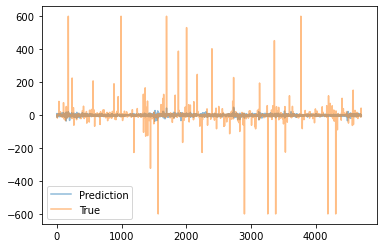

In [77]:
plt.plot(np.sum(results.params*X, axis=1), label='Prediction', alpha=0.5)
plt.plot(y, label='True', alpha=0.5)
plt.legend()

Text(0.5, 1.0, 'Error in percentage')

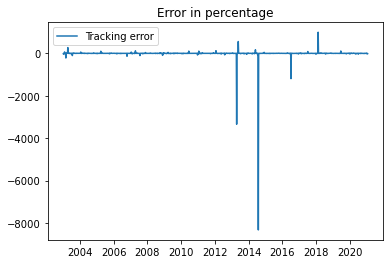

In [106]:
plt.plot((y-np.sum(results.params*X, axis=1))/y, label='Tracking error')
plt.legend()
plt.title('Error in percentage')

In [79]:
new_df.bfill()[new_df.columns[1:-1]].columns

Index(['GDAM Index', 'GDAO Index', 'GDAR Index', 'GDAW Index', 'GDAZ Index',
       'GDBB Index', 'GDBG Index', 'GDBH Index', 'GDBO Index', 'GDBR Index',
       'GDBS Index', 'GDBY Index', 'GDBZ Index', 'GDCI Index', 'GDCL Index',
       'GDCN Index', 'GDCO Index', 'GDCR Index', 'GDCS Index', 'GDDO Index',
       'GDDZ Index', 'GDEC Index', 'GDEG Index', 'GDES Index', 'GDFJ Index',
       'GDGA Index', 'GDGE Index', 'GDGH Index', 'GDGR Index', 'GDGT Index',
       'GDHN Index', 'GDHR Index', 'GDHU Index', 'GDID Index', 'GDIL Index',
       'GDIQ Index', 'GDIS Index', 'GDJM Index', 'GDJO Index', 'GDKE Index',
       'GDKR Index', 'GDKZ Index', 'GDLB Index', 'GDLK Index', 'GDLT Index',
       'GDLV Index', 'GDMA Index', 'GDMN Index', 'GDMX Index', 'GDMY Index',
       'GDMZ Index', 'GDNA Index', 'GDNG Index', 'GDPA Index', 'GDPE Index',
       'GDPH Index', 'GDPK Index', 'GDPL Index', 'GDPY Index', 'GDQA Index',
       'GDRO Index', 'GDRU Index', 'GDRW Index', 'GDSI Index', 'GDSK Index',

## Rolling OLS of the assets' returns on the GBI EM

In [107]:
X

,GDAO Index,GDAR Index,GDAW Index,GDAZ Index,GDBB Index,GDBG Index,GDBH Index,GDBO Index,GDBR Index,GDBS Index,...,GDTN Index,GDTR Index,GDTT Index,GDUA Index,GDUY Index,GDVE Index,GDVN Index,GDZA Index,GDZM Index,const
key_0,,,,,,,,,,,,,,,,,,,,,
2003-01-05,0.000,0.0,0.000,0.000,0.000,-0.050,0.000,300.0000,2.540,0.000,...,0.999,1.283,0.000,0.868,1.629,-3.701,0.000,0.238,0.000,1
2003-01-12,0.000,0.0,0.000,0.000,0.000,2.083,0.000,500.0000,4.163,0.000,...,0.140,-1.424,0.000,0.928,4.435,-2.527,0.000,-0.030,0.000,1
2003-01-19,0.000,0.0,0.000,0.000,0.000,0.138,0.000,500.0000,-1.602,0.000,...,-0.099,-0.763,0.000,0.472,5.477,-2.163,0.000,0.808,0.000,1
2003-01-26,0.000,0.0,0.000,0.000,0.000,0.988,0.000,500.0000,-4.603,0.000,...,0.829,0.572,0.000,0.643,-1.734,0.346,0.000,0.307,0.000,1
2003-02-02,0.000,0.0,0.000,0.000,0.000,0.612,0.000,500.0000,4.315,0.000,...,-0.347,0.109,0.000,0.988,-0.774,4.709,0.000,-0.111,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-20,1.605,0.0,-0.154,0.430,0.225,0.015,0.225,8.3333,0.424,-0.114,...,0.095,2.554,0.461,0.375,1.160,-4.310,0.084,0.425,0.908,1
2020-12-27,-0.793,0.0,0.087,-0.232,0.225,0.015,0.225,74.9999,0.027,-0.050,...,0.095,0.011,0.273,-0.393,0.117,-4.310,0.080,-0.206,0.271,1
2021-01-03,2.004,0.0,0.666,0.531,0.225,0.015,0.225,74.9999,0.710,0.977,...,0.095,1.121,0.056,0.681,0.631,-4.310,0.103,0.733,2.156,1


In [ ]:
window = 100
for i in range(0, len(X)-window, window):
    model = sm.OLS(y.iloc[i:i+window], X.iloc[i:i+window])
    results = model.fit()
    print(results.summary())

## Strategy based on the mean-variance

Write a function that does:
- start with a portfolio value
- estimate the weights based on the mean-variance coefficients by selecting the investible assets, computing the weights, 

In [8]:
window = 14

In [26]:
X = new_df.fillna(0)[new_df.columns[1:-1]]
y = new_df.fillna(0)[new_df.columns[-1]].clip(-600, 600)

In [83]:
i = 0
X.iloc[i:i+window]

,GDAO Index,GDAR Index,GDAW Index,GDAZ Index,GDBB Index,GDBG Index,GDBH Index,GDBO Index,GDBR Index,GDBS Index,...,GDTH Index,GDTN Index,GDTR Index,GDTT Index,GDUA Index,GDUY Index,GDVE Index,GDVN Index,GDZA Index,GDZM Index
key_0,,,,,,,,,,,,,,,,,,,,,
2003-01-05,0.0,0.0,0.0,0.0,0.0,-0.050,0.0,300.0,2.540,0.0,...,0.022,0.999,1.283,0.0,0.868,1.629,-3.701,0.0,0.238,0.0
2003-01-12,0.0,0.0,0.0,0.0,0.0,2.083,0.0,500.0,4.163,0.0,...,-0.644,0.140,-1.424,0.0,0.928,4.435,-2.527,0.0,-0.030,0.0
2003-01-19,0.0,0.0,0.0,0.0,0.0,0.138,0.0,500.0,-1.602,0.0,...,0.174,-0.099,-0.763,0.0,0.472,5.477,-2.163,0.0,0.808,0.0
2003-01-26,0.0,0.0,0.0,0.0,0.0,0.988,0.0,500.0,-4.603,0.0,...,0.824,0.829,0.572,0.0,0.643,-1.734,0.346,0.0,0.307,0.0
2003-02-02,0.0,0.0,0.0,0.0,0.0,0.612,0.0,500.0,4.315,0.0,...,-0.344,-0.347,0.109,0.0,0.988,-0.774,4.709,0.0,-0.111,0.0
2003-02-09,0.0,0.0,0.0,0.0,0.0,-0.072,0.0,500.0,0.827,0.0,...,0.132,0.362,0.012,0.0,0.089,-13.930,-0.942,0.0,0.230,0.0
2003-02-16,0.0,0.0,0.0,0.0,0.0,0.350,0.0,500.0,-0.777,0.0,...,-0.159,-0.099,0.666,0.0,0.920,-6.527,-2.448,0.0,0.724,0.0
2003-02-23,0.0,0.0,0.0,0.0,0.0,0.137,0.0,500.0,2.444,0.0,...,1.133,-0.099,1.166,0.0,1.082,2.304,0.326,0.0,0.897,0.0
2003-03-02,0.0,0.0,0.0,0.0,0.0,0.271,0.0,500.0,5.294,0.0,...,0.020,1.285,0.667,0.0,0.930,4.256,1.248,0.0,1.132,0.0


In [28]:
i = 1
list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns[:-1]))

['GDAO Index',
 'GDAR Index',
 'GDAW Index',
 'GDAZ Index',
 'GDBB Index',
 'GDBH Index',
 'GDBS Index',
 'GDBY Index',
 'GDBZ Index',
 'GDCS Index',
 'GDES Index',
 'GDFJ Index',
 'GDGA Index',
 'GDGE Index',
 'GDGH Index',
 'GDHN Index',
 'GDIQ Index',
 'GDIS Index',
 'GDKE Index',
 'GDLK Index',
 'GDLT Index',
 'GDLV Index',
 'GDMN Index',
 'GDMZ Index',
 'GDNA Index',
 'GDPY Index',
 'GDRO Index',
 'GDRW Index',
 'GDSI Index',
 'GDSN Index',
 'GDTT Index',
 'GDVN Index']

In [77]:
i = 27
tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns[:-1]))+['GDBO Index', 'GDZM Index', 'GDSK Index', 'GDCI Index']))

In [78]:
corr_mat = X[tradable].iloc[i:i+window].corr()

In [81]:
inv_corr_mat = np.linalg.inv(corr_mat)

In [82]:
inv_corr_mat

array([[ 3.47663235e+15, -2.34744372e+14,  2.56443359e+15, ...,
         1.11013100e+14,  1.84677227e+15, -6.27860167e+14],
       [ 4.77284265e+15, -1.79462443e+15,  6.50425834e+15, ...,
         9.45048099e+14,  3.15297067e+15,  6.18589105e+15],
       [ 8.57812353e+14,  1.79859216e+15, -1.51826878e+15, ...,
        -5.13345868e+14,  6.59109238e+14, -6.37699269e+14],
       ...,
       [-1.08998716e+14, -1.62437898e+15,  4.91434995e+14, ...,
        -1.10325686e+15,  9.98027485e+14, -1.14010572e+14],
       [-1.45742130e+15, -2.31350828e+15, -4.39397046e+14, ...,
         6.30890640e+14, -3.29095598e+14, -5.38654760e+14],
       [ 1.43585192e+15, -6.50086297e+14,  2.17360531e+15, ...,
        -1.54044079e+15,  3.73888735e+15, -9.66429190e+14]])

In [51]:
(np.ones(len(tradable)).dot(inv_corr_mat)).dot(np.ones(len(tradable)))

-1405290216414625.0

In [58]:
(X[tradable].iloc[i:i+window].mean().to_numpy().dot(inv_corr_mat))

array([ 3.73807207e+15,  1.37371124e+15, -5.76391868e+15, -3.16160634e+15,
       -3.46549670e+15, -2.41811066e+14, -4.49177219e+15,  6.15748905e+15,
        2.49436214e+15, -2.16926613e+15,  2.84294065e+15,  8.44825905e+15,
        1.01341256e+15, -1.77480762e+15,  5.82912702e+15,  3.08411019e+15,
        2.39471805e+15, -3.97016889e+15, -6.14723046e+15, -5.07308780e+15,
        2.26706137e+15, -3.10171713e+15,  5.98906818e+15, -8.78034099e+15,
       -1.34008689e+15, -5.87562658e+15,  9.12327242e+14,  2.17890770e+15,
        4.89964401e+15,  6.41279434e+15,  2.41718935e+14, -1.01621142e+15,
       -1.24189680e+16, -5.71165107e+14,  1.01042047e+16, -6.15043274e+15,
       -6.47983051e+15,  1.25468305e+15,  3.64325391e+15, -6.19205798e+15,
        9.59562001e+15])

In [62]:
np.linalg.inv(corr_mat).dot(corr_mat)

array([[  7.37216464,  16.79543631,   0.02870668, ...,   3.31353613,
         18.9243986 ,  -1.        ],
       [  9.26207518,  20.47686975,  -2.44411182, ...,   4.38673343,
          6.47545476,   1.        ],
       [  3.75258095,  -1.0637764 ,  -8.60336466, ...,  10.73434425,
         -6.2177794 , -11.53125   ],
       ...,
       [ -0.61137642,  -1.31073118,  -0.0228935 , ...,  -0.33070475,
          0.02117329,   0.75      ],
       [ -1.40911497,  -1.39352439,  -0.43578028, ...,   0.94321747,
         -0.42791612,  -0.484375  ],
       [ -2.25      ,  -1.        ,   1.1875    , ...,  -0.75      ,
          0.5       ,   2.        ]])